# Кластеризация. Домашнее задание

### Данные

В предложенных файлах информация с публичных слушаний Москвы по правилам землепользования и застройки (ПЗЗ). В них комментарии жителей города были застенагрофированы, проклассифицированы (за/против) и нанесены на карту. Данные предоставлены в 2 вариантах, для задания можно использовать любой:
* geo_comment.xlsx
    * **comment** - комментарий одного или списка жителей к проект
    * **multiplier** - количество авторов комментария (может быть 1, может быть список)
    * **x, y** - координаты адреса, по которому был дан определённой комментарий
    * **comment_class** - за (1) / против (-1)
* geo.xlsx - те же данные, но без текстов комментариев и по 1 голосу на строку (ранее в 1 строке могло быть **multiplier** > 1 голоса)
    * **x, y** - координаты адреса, по которому был дан определённой комментарий
    * **comment_class** - за (1) / против (-1)
    
### Обязательное задание

* визуально разделить город на районы безотносительно голосов (провести кластеризацию и вывести картинку)
* аналогично исследовать скопления голосов за и против отдельно
* *подобрать оптимальное число кластеров при помощи кода из тетрадки в конце занятия (оптимально)*
* приложить ноутбук

### Дополнительные задания
* найти наиболее активные в голосовании районы *(подсказка: DBSCAN, не плотные районы обозначены одной меткой и закрашены одним цветом, cmap='gray')*
* для тех, кто уже попробовал работу с текстом: выделить основные тематики комментариев жителей, можно использовать всю имеющуюся дополнительную информацию

In [51]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, AffinityPropagation
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score, silhouette_score
from sklearn.model_selection import train_test_split
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist
import warnings
warnings.filterwarnings('ignore')

In [2]:
geo = pd.read_excel('geo.xlsx')
geo

,Unnamed: 0,x,y,comment_class
0,0,37.612416,55.777454,-1
1,1,37.612416,55.777454,-1
2,2,37.603298,55.742108,-1
3,3,37.558526,55.728758,-1
4,4,37.566431,55.731794,-1
...,...,...,...,...
108801,108801,37.454528,55.792331,-1
108802,108802,37.384325,55.899068,-1
108803,108803,37.421066,55.848756,1
108804,108804,37.448509,55.793065,-1


In [3]:
geo_comment = pd.read_excel('geo_comment.xlsx')
geo_comment

,Unnamed: 0,x,y,comment_class,multiplier,comment
0,0,37.612416,55.777454,-1,1,Во все разделы правил землепользования и застр...
1,1,37.612416,55.777454,-1,1,На основании вступившего в законную силу судеб...
2,2,37.603298,55.742108,-1,1,Внести в Проект правил землепользования и заст...
3,3,37.558526,55.728758,-1,1,Учитывая социальную значимость проекта строите...
4,4,37.566431,55.731794,-1,1,Учитывая социальную значимость проекта строите...
...,...,...,...,...,...,...
70377,70377,37.454528,55.792331,-1,1,Не поддерживаю. Я против строительства многоэт...
70378,70378,37.384325,55.899068,-1,1,Не поддерживаю. Не нужны отстойники автобусов ...
70379,70379,37.421066,55.848756,1,1,"Не поддерживаю. На мой взгляд, необходимо искл..."
70380,70380,37.448509,55.793065,-1,1,Не поддерживаю: нарушения при строительстве н...


Задание 1. визуально разделим город на районы безотносительно голосов (проведем кластеризацию и выведем картинку)

Посмотрим, как выглядят координаты адресов на графике

In [4]:
X_coord = geo['x']
Y_coord = geo['y']
X = np.column_stack((X_coord,Y_coord))
X

array([[37.612416, 55.777454],
       [37.612416, 55.777454],
       [37.603298, 55.742108],
       ...,
       [37.421066, 55.848756],
       [37.448509, 55.793065],
       [37.451249, 55.83662 ]])

In [5]:
y = geo['comment_class']
y[y == 1] = 1
y[y == -1] = 0

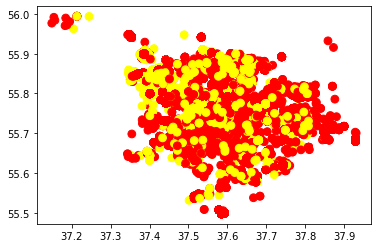

In [6]:
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='autumn', s=60)

Приведем значения по обеим осям к нормальному распределению с помощью StandardScaler

In [7]:
scaler = StandardScaler()

In [8]:
X_scaled = scaler.fit_transform(X)

Видим, что график остался тем же, однако значения отмасштабированы

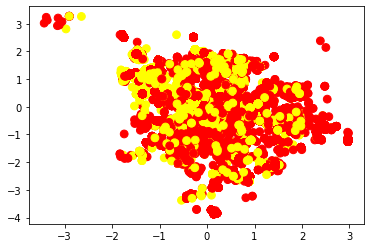

In [9]:
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=y, cmap='autumn', s=60)

Проведем кластеризацию с использованием KMeans

In [10]:
clf_kmeans = KMeans(n_clusters=3)
clusters_kmeans = clf_kmeans.fit_predict(X_scaled, )

Проведем кластеризацию с использованием DBSCAN

In [11]:
clf_dbscan = DBSCAN()
clusters_dbscan = clf_dbscan.fit_predict(X_scaled, )

При использовании Affinity Propogation и Aglomerative Clustering Kernel умирает, поэтому я их исключила из рассмотрения.
Одновременно можно было бы попробовать уменьшить размер датасета - есть предположение, что это из-за большого объема данных.

Text(0.5, 1.0, 'DBSCAN')

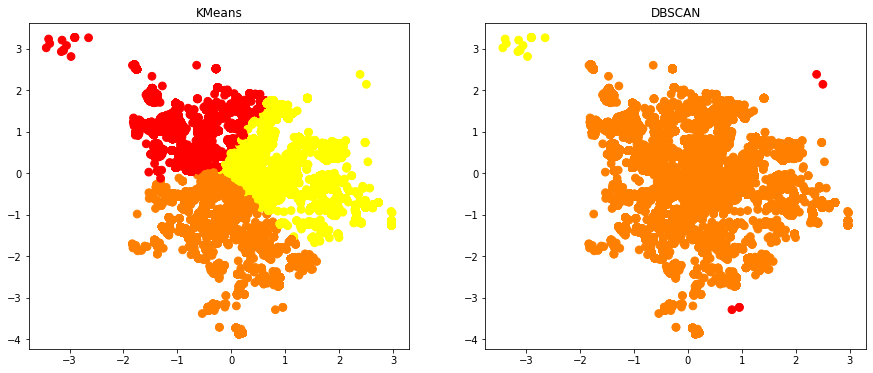

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
axes[0].scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters_kmeans, cmap='autumn', s=60)
axes[0].set_title('KMeans')
axes[1].scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters_dbscan, cmap='autumn', s=60)
axes[1].set_title('DBSCAN')

Задание 2. Подберем оптимальное число кластеров для Kmeans

In [13]:
k_inertia = []
ks = range(1,11)

for k in ks:
    clf_kmeans = KMeans(n_clusters=k)
    clusters_kmeans = clf_kmeans.fit_predict(X_scaled, )
    k_inertia.append(clf_kmeans.inertia_)

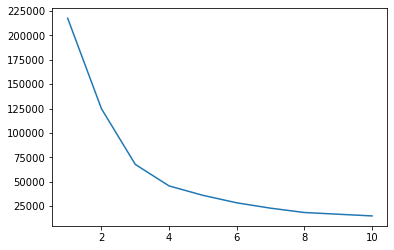

In [14]:
plt.plot(ks, k_inertia)

In [15]:
diff = np.diff(k_inertia)

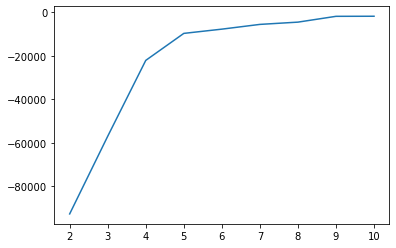

In [16]:
plt.plot(ks[1:], diff)

In [17]:
diff_r = diff[1:] / diff[:-1]

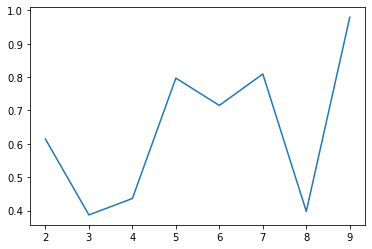

In [18]:
plt.plot(ks[1:-1], diff_r)

Получаем, что оптимальное число кластеров для метода равно 3. Именно такое значение было изначально принято в качестве исходного для кластеризации

In [19]:
k_opt = ks[np.argmin(diff_r)+1]
k_opt

3

Подберем оптимальное число кластеров для DBSCAN

In [20]:
clf_dbscan01 = DBSCAN(eps = 0.1)
clusters_dbscan01 = clf_dbscan01.fit_predict(X_scaled, )

In [21]:
clf_dbscan025 = DBSCAN(0.25)
clusters_dbscan025 = clf_dbscan025.fit_predict(X_scaled, )

Путем изменения eps подбираем оптимальное количество кластеров для DBSCAN

Text(0.5, 1.0, 'DBSCAN, eps = 0.25')

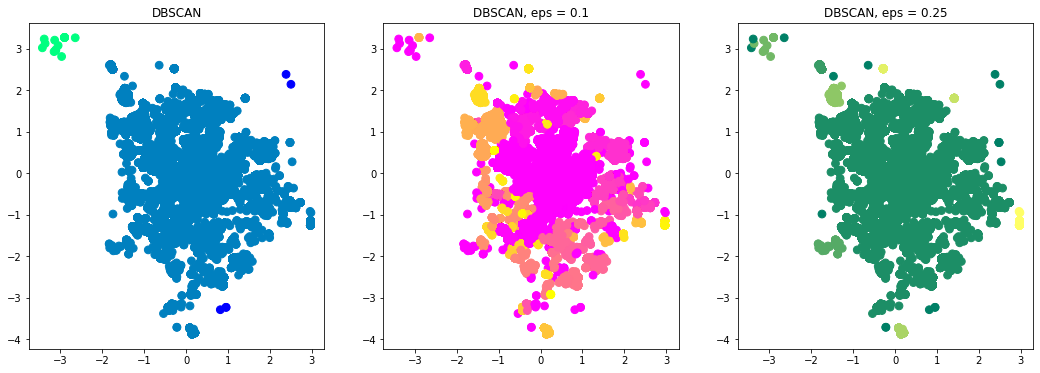

In [22]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes[0].scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters_dbscan, cmap='winter', s=60)
axes[0].set_title('DBSCAN')
axes[1].scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters_dbscan01, cmap='spring', s=60)
axes[1].set_title('DBSCAN, eps = 0.1')
axes[2].scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters_dbscan025, cmap='summer', s=60)
axes[2].set_title('DBSCAN, eps = 0.25')

Попробуем реализовать Affinity Propogation и Aglomerative Clustering Kernel, применяя меньшую выборку. Уменьшение выборки проведем путем использования train_test_split. Выборку сократили до 5%, даже на 10% требуется много ресурсов для подсчета

In [37]:
random_seed = 42
X_train, X_test, y_train, y_test = train_test_split(X_scaled,y,test_size = 0.05,random_state=random_seed)

In [38]:
X_test.shape

(5441, 2)

In [39]:
clf_ap = AffinityPropagation()
clusters_ap = clf_ap.fit_predict(X_test, )

In [40]:
clf_ac = AgglomerativeClustering(n_clusters=3)
clusters_ac = clf_ac.fit_predict(X_test, )

Text(0.5, 1.0, 'Aglomerative Clustering')

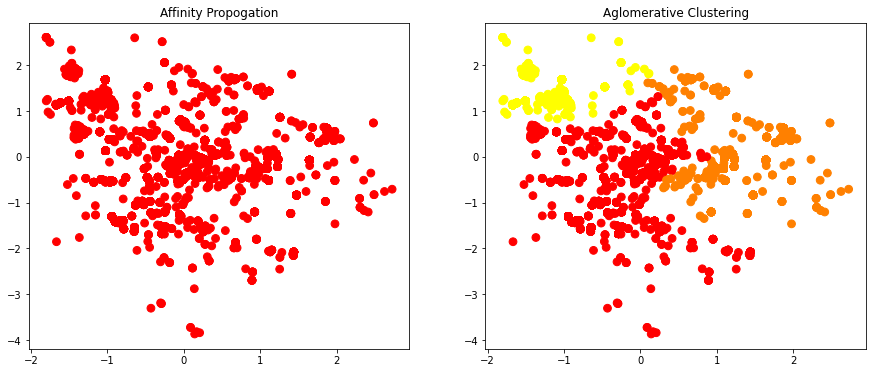

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
axes[0].scatter(X_test[:, 0], X_test[:, 1], c=clusters_ap, cmap='autumn', s=60)
axes[0].set_title('Affinity Propogation')
axes[1].scatter(X_test[:, 0], X_test[:, 1], c=clusters_ac, cmap='autumn', s=60)
axes[1].set_title('Aglomerative Clustering')

Построим дендрограмму для AgglomerativeClustering

In [44]:
def plot_dendrogram(model, **kwargs):
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1 
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)
    dendrogram(linkage_matrix, **kwargs)

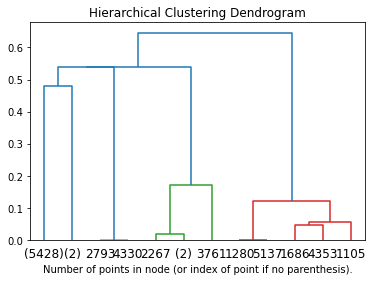

In [47]:
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage='single')

model = model.fit(X_test)
plt.title('Hierarchical Clustering Dendrogram')
plot_dendrogram(model, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

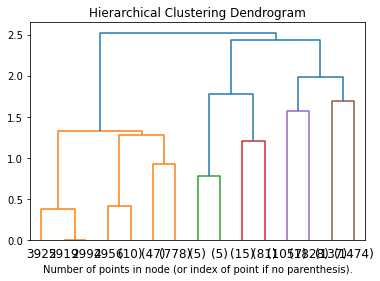

In [48]:
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage='average')

model = model.fit(X_test)
plt.title('Hierarchical Clustering Dendrogram')
plot_dendrogram(model, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

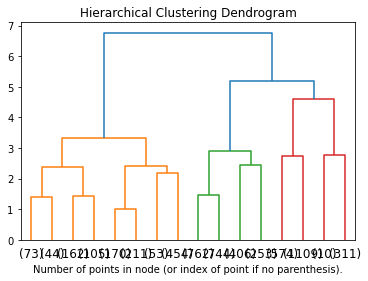

In [49]:
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage='complete')

model = model.fit(X_test)
plt.title('Hierarchical Clustering Dendrogram')
plot_dendrogram(model, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

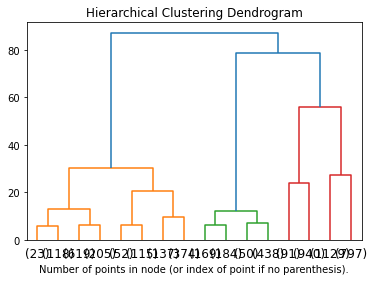

In [50]:
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage='ward')

model = model.fit(X_test)
plt.title('Hierarchical Clustering Dendrogram')
plot_dendrogram(model, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

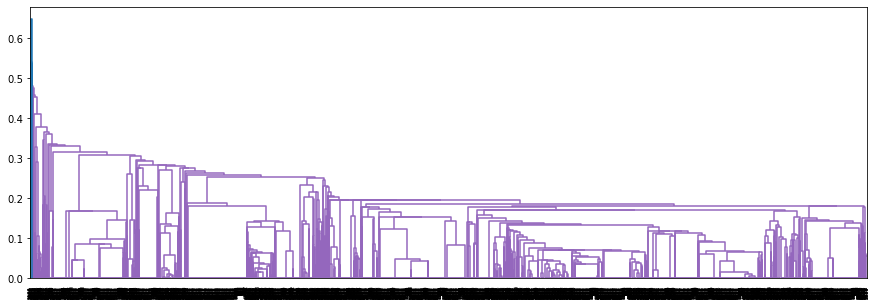

In [52]:
distance_mat = pdist(X_test)

Z = hierarchy.linkage(distance_mat, 'single')
plt.figure(figsize=(15,5))
dn = hierarchy.dendrogram(Z,color_threshold=0.5)

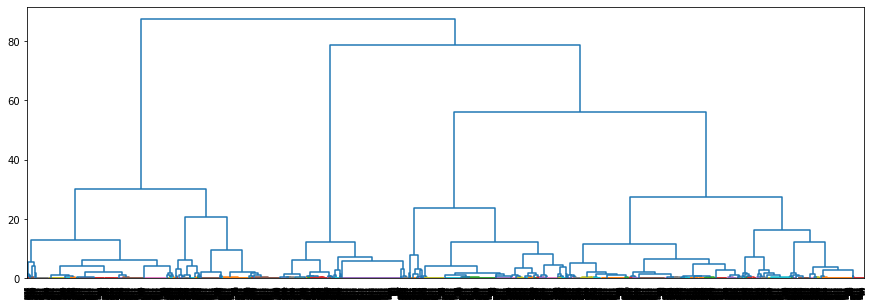

In [53]:
Z = hierarchy.linkage(distance_mat, 'ward')
plt.figure(figsize=(15,5))
dn = hierarchy.dendrogram(Z,color_threshold=0.5)